In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import random
import arviz as az
import pymc as pm
import pymc.sampling.jax as pmjax
import numpy as np

import sys; sys.path.append('../')
from misc import h5file
import yaml
import statsmodels.api as sm

In [2]:
noise_lv = 30
fp1 = "./IPI_output_files/PMS_data.h5"
fp2 = "./IPI_output_files/encoded_pde_names.yaml"
X_pre, best_subsets, un, y_pre = h5file(file_path=fp1, mode='r', return_dict=False)

with open(fp2, 'r') as f:
    config = yaml.load(f, yaml.Loader)
f.close()
encoded_feature_names = config["encoded_feature_names"]
encoded_pde_names = config["encoded_pde_names"]
encoded_pde_names

['X_pre', 'best_subsets', 'un', 'y_pre']


['u*u_1',
 'u_111+u*u_1',
 'u_111+u*u_1+u*u_111',
 'u_111+u*u_1+u*u*u_1+u*u_111',
 'u_1+u_111+u*u_1+u*u_111+u*u*u_111',
 'u+u_1+u_111+u*u_1+u*u_111+u*u*u_111',
 'u+u_1+u_111+u*u_1+u*u_11+u*u_111+u*u*u_111',
 'u+u_1+u_111+u*u_1+u*u*u_1+u*u_11+u*u_111+u*u*u_111',
 'u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u_111+u*u*u_111',
 'u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111',
 'u+u*u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111',
 'u+u*u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111+u*u_1111',
 'u+u*u+u_1+u_11+u_111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111+u*u_1111+u*u*u_1111',
 'u+u*u+u_1+u_11+u_111+u_1111+u*u_1+u*u*u_1+u*u_11+u*u*u_11+u*u_111+u*u*u_111+u*u_1111+u*u*u_1111']

In [3]:
bic_sel_complexity = 7
max_complexity = len(best_subsets)//2
hie = [np.where(best_subsets[i]>0)[0].tolist() for i in range(best_subsets.shape[-1])][:max_complexity]
hie

[[6],
 [4, 6],
 [4, 6, 10],
 [4, 6, 7, 10],
 [2, 4, 6, 10, 11],
 [0, 2, 4, 6, 10, 11],
 [0, 2, 4, 6, 8, 10, 11]]

In [4]:
### Version 1 ###
# Define the Bayesian linear regression model
X_sup = X_pre[:, hie[-1]]
y_sup = y_pre.ravel()
support_sizes = X_sup.shape[-1]
init_beta = np.linalg.lstsq(X_sup, y_sup, rcond=-1)[0]
init_sigma = np.mean((X_sup@init_beta-y_sup)**2)
print(init_beta, init_sigma)
n_samples = 4000
# n_samples = 40
pinclusion = (bic_sel_complexity/len(best_subsets))/2 # normal pinclusion (0.25)
pinclusion = (bic_sel_complexity/len(best_subsets))/4 # low pinclusion (0.125)
pinclusion = 1e-2 # lowlow pinclusion (0.001)

np.random.seed(0)
with pm.Model() as model:
    # beta = pm.Normal('beta', mu=0, sigma=1, shape=X_sup.shape[-1])
    # sigma = pm.HalfCauchy('sigma', beta=init_sigma)
    
    xi = pm.Bernoulli('xi', pinclusion, shape=support_sizes)
    beta = pm.MvNormal('beta', 
                       mu=init_beta.flatten(), cov=np.identity(support_sizes), 
                       shape=support_sizes)
    coeffs = pm.Deterministic('coeffs', beta*xi)
    sigma = pm.Exponential('sigma', lam=init_sigma)
    mu = pm.math.dot(X_sup, coeffs)
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_sup)

    # Perform MCMC sampling
    trace = pm.sample(n_samples, tune=n_samples//2, chains=4, cores=4, 
                      # nuts={'target_accept':0.99}, 
                      nuts={'target_accept':0.99, 'max_treedepth':12}, 
                      return_inferencedata=True)
    # trace = pmjax.sample_numpyro_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=return_inferencedata)
    # trace = pmjax.sample_blackjax_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=True)
    pm.compute_log_likelihood(trace)
    idata = pm.sample_smc(draws=n_samples, progressbar=False, cores=4)

[-0.00272839 -0.02550555 -0.90364348 -0.96685633 -0.00405048 -0.19253602
  0.07679068] 0.004769484870843118


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [beta, sigma]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 2878 seconds.
/Users/pongpisit/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3822 divergences after tuning. Increase `target_accept` or reparameterize.


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/Users/pongpisit/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [5]:
# trace.to_netcdf("kdv_99_depth12_1e-2_pinclusion.trace", overwrite_existing=True)
# idata.to_json("kdv_99_depth12_1e-2_pinclusion_idata.json")

'kdv_99_depth12_1e-2_pinclusion_idata.json'

In [6]:
# ### Version 2 (relaxed & faster) ###
# # Define the Bayesian linear regression model
# init_beta = np.linalg.lstsq(X_pre, y_pre, rcond=-1)[0]
# init_sigma = np.mean((X_pre@init_beta-y_pre)**2)
# thin_sigma = 1e-2
# fat_sigma = 1

# n_samples = 4000
# # n_samples = 40

# X_sup = X_pre
# y_sup = y_pre.ravel()
# support_sizes = X_sup.shape[-1]

# np.random.seed(0)
# with pm.Model() as model:    
#     pinclusion = pm.Uniform("pip", 0.0, (5/support_sizes)/2)
#     pip = pm.Bernoulli('xi', pinclusion, shape=support_sizes)
#     coeffs = pm.Normal("coeffs", mu=0, sigma=(1-pip)*thin_sigma+pip*fat_sigma)
# #     coeffs = pm.MvNormal("beta", mu=init_beta.flatten(), 
# #                          sigma=((1-inclusion)*thin_sigma+inclusion*fat_sigma)*np.identity(support_sizes))
    
#     sigma = pm.Exponential('sigma', lam=init_sigma)
#     mu = pm.math.dot(X_sup, coeffs)
#     likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_sup)

#     # Perform MCMC sampling
#     trace = pm.sample(n_samples, tune=n_samples//2, chains=4, cores=4, 
#                       # nuts={'target_accept':0.99}, 
#                       nuts={'target_accept':0.99, 'max_treedepth':12}, 
#                       return_inferencedata=True)
#     # trace = pmjax.sample_numpyro_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=return_inferencedata)
#     # trace = pmjax.sample_blackjax_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=True)
#     pm.compute_log_likelihood(trace)
#     idata = pm.sample_smc(draws=n_samples, progressbar=False, cores=4)

In [84]:
post = idata.posterior
post_coeff = post.coeffs
post_xi = post.xi

In [85]:
# import json
# trace = trace.from_netcdf("kdv_99_depth12_low_pinclusion.trace")
# with open('kdv_99_depth12_low_pinclusion_idata.json') as f:
#     idata = json.load(f)
# post_coeff = idata['posterior']['coeffs']
# post_xi = idata['posterior']['xi']

In [86]:
# xi_npar = np.array(post.xi)
xi_npar = np.array(post_xi)
total_samples = xi_npar.shape[0]*xi_npar.shape[1]
coll = {}
tested = {}
for nc in range(xi_npar.shape[0]):
    for i in range(xi_npar.shape[1]):
        eff = tuple(np.nonzero(xi_npar[nc][i])[0])
        if eff not in tested:
            com = len(eff)
            bicv = sm.OLS(y_sup, X_sup[:, eff]).fit().bic
            if (com not in coll) or (com in coll and coll[com][-1] > bicv):
                coll[len(eff)] = [eff, bicv]
            tested[eff] = 1
        else:
            tested[eff] += 1
for com in coll: 
    coll[com].append(tested[coll[com][0]])
counts = [tested[coll[com][0]] for com in coll]
counts = np.array(counts)
# counts = counts/sum(counts)
counts = counts/total_samples
coll

{2: [(2, 3), -24202.09802250475, 15840],
 3: [(2, 3, 5), -24516.283556873415, 159]}

In [87]:
data = np.array(post_coeff).reshape(-1, support_sizes)
prob = np.array(post_xi).reshape(-1, support_sizes)
prob = prob.mean(axis=0)
# prob = prob/sum(prob)
index = tuple(sorted(np.argsort(prob)[::-1][:max(coll.keys())]))
data = data[:, index]

In [88]:
encoded_feature_names = ['$u$', '$u^{2}$', '$u_{x}$', '$u_{xx}$', '$u_{xxx}$', '$u_{xxxx}$', '$uu_{x}$', '$u^{2}u_{x}$', 
                         '$uu_{xx}$', '$u^{2}u_{xx}$', '$uu_{xxx}$', '$u^{2}u_{xxx}$', '$uu_{xxxx}$', '$u^{2}u_{xxxx}']
columns = [encoded_feature_names[hie[-1][i]] for i in index]
columns

['$u_{xxx}$', '$uu_{x}$', '$uu_{xxx}$']

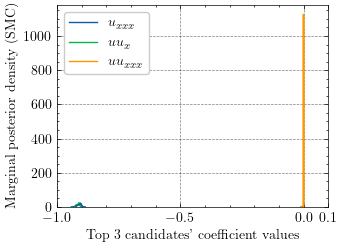

In [89]:
with plt.style.context(['science', 'grid']):
    sns.kdeplot(data)
#     sns.kdeplot(pd.DataFrame(data, columns=['$uu_{x}$', '$u_{xxx}$', '$u_{x}$', '$uu_{xxx}$', '$u^{2}u_{xxx}$', '$u$', '$uu_{xx}$']))
    sns.kdeplot(pd.DataFrame(data, columns=columns))
    plt.xlabel(f"Top {len(columns)} candidates' coefficient values")
#     plt.ylabel("Marginal posterior density (MCMC)")
    plt.ylabel("Marginal posterior density (SMC)")
    plt.xticks([-1., -0.5, 0, 0.1])
    # plt.ylim(0, 1000)
#     plt.savefig("../Figures/KdV/posterior_smc_lowlow_pinclusion.pdf")
    plt.show()

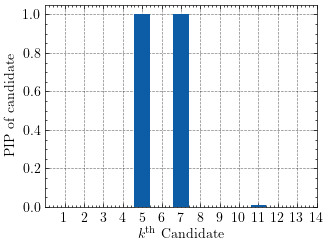

In [90]:
with plt.style.context(['science', 'grid']):
    plt.bar([i+1 for i in hie[-1]], prob)
    plt.xticks([i+1 for i in range(len(best_subsets))])
    plt.ylabel("PIP of candidate")
    plt.xlabel("$k^{\\text{th}}$ Candidate")
#     plt.savefig("../Figures/KdV/PIP_candidate_smc_lowlow_pinclusion.pdf")
    plt.show()

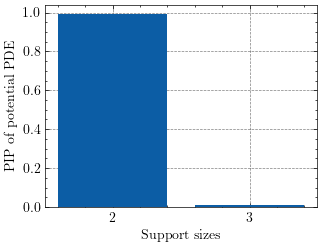

In [91]:
with plt.style.context(['science', 'grid']):
    plt.bar(coll.keys(), counts)
    plt.xticks(list(coll.keys()))
    plt.ylabel("PIP of potential PDE")
    plt.xlabel("Support sizes")
#     plt.savefig("../Figures/KdV/PIP_model_smc_lowlow_pinclusion.pdf")
    plt.show()

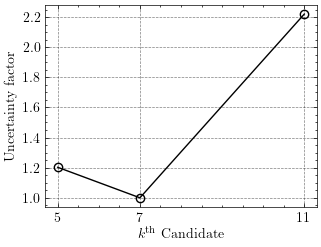

In [92]:
map_est = np.linalg.lstsq(X_sup[:, index], y_sup, rcond=None)[0]
uncert = np.abs(data.std(axis=0)/map_est)
uncert = uncert/min(uncert)

with plt.style.context(['science', 'grid']):
    plt.plot([hie[-1][i]+1 for i in index], uncert, 'o-', c='black', markerfacecolor='none')
    plt.xticks([hie[-1][i]+1 for i in index])
#     plt.title("Spike and slap prior")
    plt.xlabel("$k^{\\textrm{th}}$ Candidate")
    plt.ylabel("Uncertainty factor")
#     plt.savefig("../Figures/KdV/ss_uncert_smc_lowlow_pinclusion.pdf")
    plt.show()